# Modis Land Cover Maps
<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 07/29/2016 <br/>
</h3>

# Setup

In [71]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import flood_functions
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio 
import seaborn as sns
import statsmodels.api as sm

from IPython.display import display, HTML
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
print 'Matplotlib Styles:', '\n'.join(plt.style.available)

Matplotlib Styles: seaborn-darkgrid
seaborn-notebook
classic
seaborn-ticks
grayscale
bmh
seaborn-talk
dark_background
ggplot
fivethirtyeight
seaborn-colorblind
seaborn-deep
seaborn-whitegrid
seaborn-bright
seaborn-poster
seaborn-muted
seaborn-paper
seaborn-white
seaborn-pastel
seaborn-dark
seaborn-dark-palette


In [35]:
%pylab inline
#%matplotlib

plt.style.use('ggplot')
sns.set(font_scale=1.5)
fig_large = (18,9.9)
fig_small = (9,4.45)

Populating the interactive namespace from numpy and matplotlib


In [5]:
# define directories
dir_python_data = '../Data/'
dir_modis = '../../Raw Data/Modis Land Cover/'

# Load Data

## Land Mask

In [6]:
# lowres land mask
f = open(dir_python_data + 'grace_land_mask_lowres.p', 'rb')
land_mask = pickle.load(f)
f.close()

land_mask = np.flipud(land_mask.transpose())

## MODIS

In [7]:
# modis meta data
f = open(dir_modis + 'modis_land_coverage_meta.txt', 'r')
modis_meta = f.read()
print modis_meta

nrows	296
ncols	720
xllcorner	-180.0
yllcorner	-64.0
cellsize	0.5
NODATA_value	255


In [8]:
# modis land cover values
f = open(dir_modis + 'modis_land_coverage_values.txt', 'r')
modis_values = f.read()

# convert to 2d
modis_array = np.array([int(s) for s in modis_values.split()])
modis_2d = modis_array.reshape((296,720))

# shift longistude values
modis_2d_h1 = modis_2d[:,0:360]
modis_2d_h2 = modis_2d[:,360:]
modis_2d_shift = np.hstack((modis_2d_h2,modis_2d_h1))

# fill in missing lat and lon values
top = np.zeros((12,720))
bot = np.zeros((52,720))
modis_2d_stack = np.vstack((top,modis_2d_shift,bot))

(360, 720)


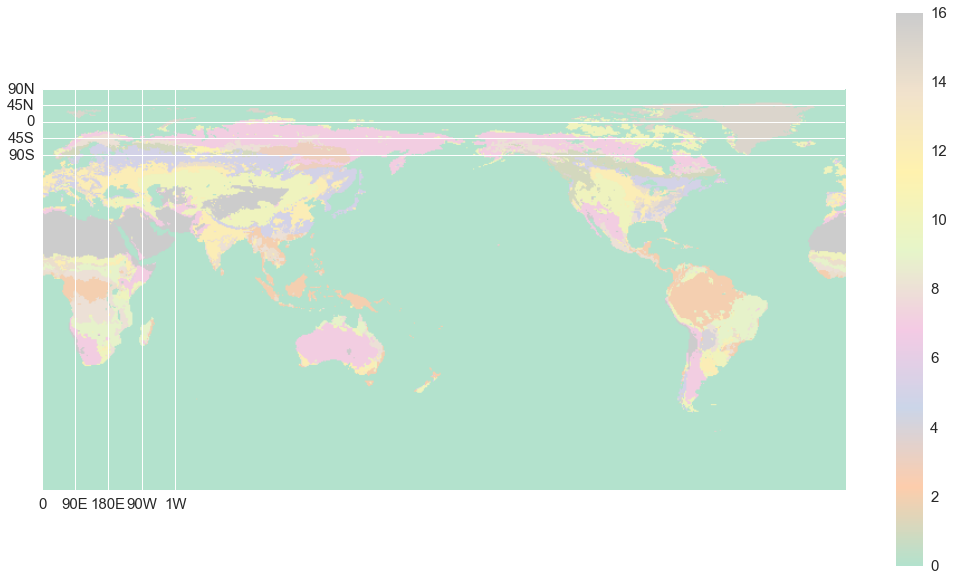

In [138]:
print modis_2d_stack.shape
plt.figure(figsize=fig_large)
plt.imshow(modis_2d_stack, cmap='Pastel2')
plt.xticks([0, 29, 59, 89, 119], ['0', '90E','180E', '90W', '1W'])
plt.yticks([0, 14, 29, 44, 59], ['90N', '45N','0', '45S', '90S'])
plt.colorbar()
plt.show()

# Create Land Coverage Masks

In [131]:
def mask_out_land_cover(land_cover_nums, modis_map):

    # create empty mask
    bool_map_sum = np.zeros(modis_map.shape)

    # create high resolution mask
    for num in land_cover_nums:
        bool_map = modis_map == num
        bool_map_sum += bool_map.astype(int)

    bool_map_sum[bool_map_sum > 0] = 1
    bool_map_sum[bool_map_sum == 0] = np.nan
    modis_mask = bool_map_sum

    # convert to low resolution
    modis_mask_lowres = grace_2d_convert_lowres(modis_mask, 6)

    # use cells that are 50% land coverage type in lowres mask
    modis_mask_lowres[modis_mask_lowres < 0.5] = np.nan
    modis_mask_lowres[modis_mask_lowres >= 0.5] = 1

    return modis_mask_lowres

In [137]:
# single value masks
modis_water = mask_out_land_cover([0], modis_2d_stack.copy())
modis_evergreen_needle_forest = mask_out_land_cover([1], modis_2d_stack.copy())
modis_evergreen_broadleaf_forest = mask_out_land_cover([2], modis_2d_stack.copy())
modis_deciduous_needleleaf_forest = mask_out_land_cover([3], modis_2d_stack.copy())
modis_deciduous_broadleaf_forest = mask_out_land_cover([4], modis_2d_stack.copy())
modis_mixed_forest = mask_out_land_cover([5], modis_2d_stack.copy())
modis_closed_shrublands = mask_out_land_cover([6], modis_2d_stack.copy())
modis_open_shrublands = mask_out_land_cover([7], modis_2d_stack.copy())
modis_woody_savannas = mask_out_land_cover([8], modis_2d_stack.copy())
modis_savannas = mask_out_land_cover([9], modis_2d_stack.copy())
modis_grasslands = mask_out_land_cover([10], modis_2d_stack.copy())
modis_permanent_wetlands = mask_out_land_cover([11], modis_2d_stack.copy())
modis_croplands = mask_out_land_cover([12], modis_2d_stack.copy())
modis_urban_built_up = mask_out_land_cover([13], modis_2d_stack.copy())
modis_cropland_natural_vegetation = mask_out_land_cover([14], modis_2d_stack.copy())
modis_snow_ice = mask_out_land_cover([15], modis_2d_stack.copy())
modis_barren_sparsely_vegetated = mask_out_land_cover([16], modis_2d_stack.copy())

# combination value masks
modis_cmb_forest = mask_out_land_cover([1,2,3,4,5], modis_2d_stack.copy())
modis_cmb_shrublands = mask_out_land_cover([6,7], modis_2d_stack.copy())
modis_cmb_savannas = mask_out_land_cover([8,9], modis_2d_stack.copy())

## Coastal Inverse

In [138]:
# create inverse coastal land cover mask
modis_coastal_inverse = modis_water.copy()
modis_coastal_inverse[modis_coastal_inverse > 0] = -1
modis_coastal_inverse[modis_coastal_inverse == 0] = 1
modis_coastal_inverse[modis_coastal_inverse == -1] = 0

/Users/aarontrefler_temp2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


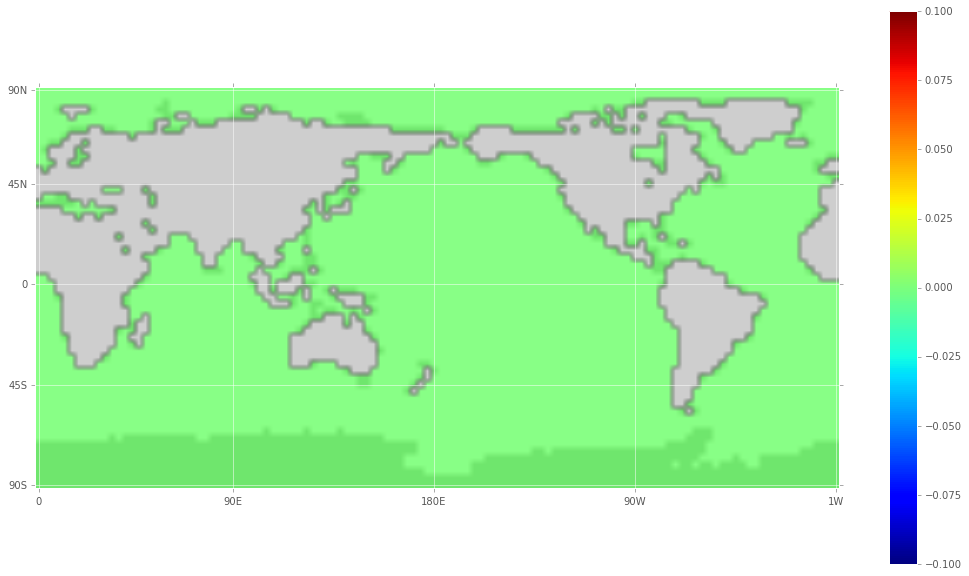

In [139]:
# plot
plt.figure(figsize=fig_large)
title('')

plt.imshow(modis_coastal_inverse)
plt.xticks([0, 29, 59, 89, 119], ['0', '90E','180E', '90W', '1W'])
plt.yticks([0, 14, 29, 44, 59], ['90N', '45N','0', '45S', '90S'])
plt.colorbar()

# plot land mask
plt.imshow(land_mask, cmap='binary', alpha=0.1)

plt.show()

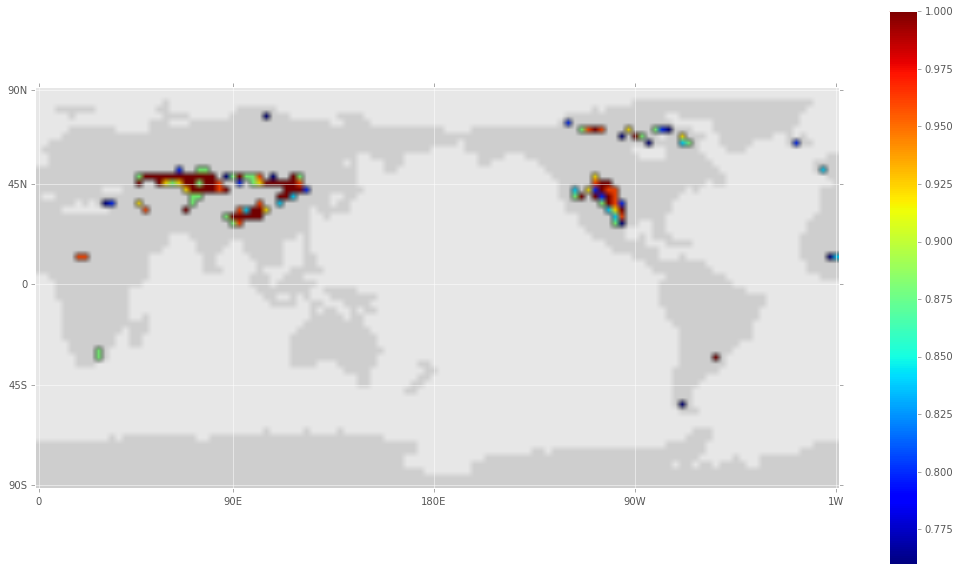

In [140]:
# plot
plt.figure(figsize=fig_large)
title('')

plt.imshow(modis_grasslands)
plt.xticks([0, 29, 59, 89, 119], ['0', '90E','180E', '90W', '1W'])
plt.yticks([0, 14, 29, 44, 59], ['90N', '45N','0', '45S', '90S'])
plt.colorbar()

# plot land mask
plt.imshow(land_mask, cmap='binary', alpha=0.1)

plt.show()

# Save Data

In [141]:
# pickle land cover masks
modis_mask_dict = {
    'modis_coastal': modis_water,
    'modis_evergreen_needle_forest': modis_evergreen_needle_forest,
    'modis_evergreen_broadleaf_forest': modis_evergreen_broadleaf_forest,
    'modis_deciduous_needleleaf_forest': modis_deciduous_needleleaf_forest,
    'modis_deciduous_broadleaf_forest': modis_deciduous_broadleaf_forest,
    'modis_mixed_forest': modis_mixed_forest,
    'modis_closed_shrublands': modis_closed_shrublands,
    'modis_open_shrublands': modis_open_shrublands,
    'modis_woody_savannas': modis_woody_savannas,
    'modis_savannas': modis_savannas,
    'modis_grasslands': modis_grasslands,
    'modis_permanent_wetlands': modis_permanent_wetlands,
    'modis_croplands': modis_croplands,
    'modis_urban_built_up': modis_urban_built_up,
    'modis_cropland_natural_vegetation': modis_cropland_natural_vegetation,
    'modis_snow_ice': modis_snow_ice,
    'modis_barren_sparsely_vegetated': modis_barren_sparsely_vegetated
    }

# pickle grace features
f = open(dir_python_data + 'modis_mask_dict.p', 'wb') 
pickle.dump(modis_mask_dict,f, -1)
f.close()